# MNIST Latent Manifold: Comparing Gaussian-smoothed diffusion with KDE
- In this notebook, we train a VAE on MNIST (set up to load pretrained params)
- We consider a single digit class of the dataset, which constitutes a lower-dimensional structure in the latent space
- The whole set of digits is used as a proxy for the underlying structure, and the empirical dataset consists of a subset of points of size 100
- We perform Gaussian-smoothed diffusion in the latent space to generate samples, and do similarly for KDE
- For the generated samples, we report the following:
    - $L_2$ distance to manifold, relative to the $L_2$ distance to the empirical dataset (in the latent space; this is implicitly controlled by changing the smoothing parameter).
    - We also plot individual reconstructed samples for both methods, as the smoothing levels increase. The quality of reconstruction can be used as a proxy for whether the manifold structure is preserved.

In [2]:
import os  # before importing anything jax
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'
os.environ['CUDA_VISIBLE_DEVICES']='1'

import jax
import jax.numpy as jnp

import numpy as np

import matplotlib.pyplot as plt

import pickle as pkl

from src.diffusion import VE_diffuser, log_hat_pt, empirical_eps_fn, sample_rev
from src.plotting import plot_images, add_arrows
from src.smoothing import get_smoothed_fn
from src.vae import create_vae

# plot formatting
import seaborn as sns
from matplotlib.lines import Line2D
sns.set_theme()  # sets a nicer global style for plots
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'font.family': 'serif'})

## load mnist data
- reshape to (32,32,1)
- use the MNIST test set of 10,000 samples for the VAE training

(60000, 32, 32, 1)


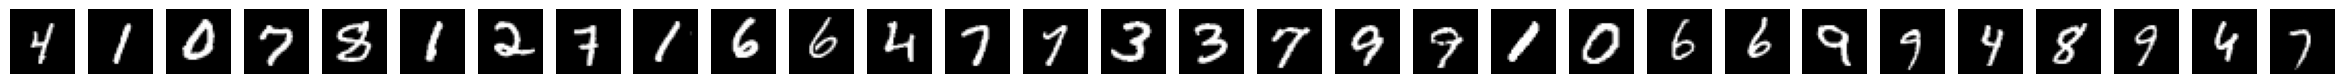

In [3]:
def pad_to_32(batch):
    """
    Pad the batch of images from (28, 28, 1) to (32, 32, 1).
    Args:
        batch: jnp array of shape (batch_size, 28, 28, 1)
    Returns:
        jnp array of shape (batch_size, 32, 32, 1)
    """
    return jnp.pad(batch, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant')

# Example usage
all_images = jnp.load('data/train_images.npy')
all_images = pad_to_32(all_images)

all_images = all_images / 255.0 # Normalize pixel values to be between 0 and 1

print(all_images.shape)  # Output: (60000, 32, 32, 1)
plot_images(all_images[:30], n=30)

# define which ones to use for the VAE training
vae_images = jnp.load('data/test_images.npy')
vae_images = pad_to_32(vae_images)
vae_images = vae_images / 255.0

diffusion_images = all_images

## train/load VAE

In [4]:
vae_config = {
    'model_config': {
        'dim_init': 16,
        'kernel_size': 3,
        'dim_mults': (1, 2, 2, 2),
        'num_groups': 4,
        'latent_dim': 32,
        'dropout': 0.1
    },
    'training_config': {
        'learning_rate': 1e-3,
        'batch_size': 64,
        'num_steps': 10000,
        'num_checkpoints': 5,
    }
}

rng = jax.random.PRNGKey(0)
vae, init_params = create_vae(rng, vae_config['model_config'])

# params, losses, params_lst = vae.train(rng, init_params, vae_images, vae_config['training_config'])
# plt.plot(losses)
# plt.yscale('log')

# # Save params
# with open('params/vae_params.pkl', 'wb') as f:
#     pkl.dump(params, f)

# Load pretrained params
with open('params/vae_params.pkl', 'rb') as f:
    params = pkl.load(f)

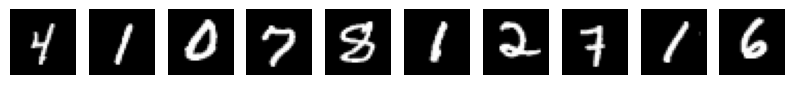

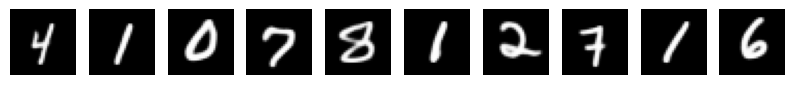

In [5]:
# check reconstructions
test_samples = all_images[:10]

reconstructions, means, log_vars = vae.apply(params, test_samples, train=False, rngs={'dropout': rng})

plot_images(test_samples)
plot_images(reconstructions)

## consider a single class, for the manifold and the empirical dataset

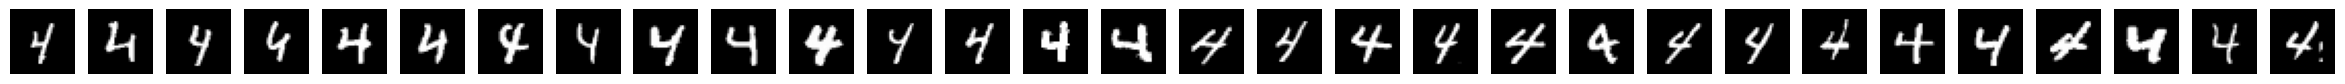

In [6]:
diffusion_labels = jnp.load('data/train_labels.npy')

digit = 4
idxs = jnp.where(diffusion_labels == digit)[0] #4
plot_images(diffusion_images[idxs], n=30)
filtered_train_images = diffusion_images[idxs]

## examining the latent space
- We first verify that the chosen datapoints comprise a lower-dimensional structure in the latent space

In [7]:
latent_filtered_images = vae.apply(params, filtered_train_images, train=False, rngs={'dropout': rng})[1]  # Get latent representations

decoded_filtered_images = vae.apply(params, latent_filtered_images, method=vae.decode)  # Decode back to images

filtered_train_images.shape, latent_filtered_images.shape

W0114 16:44:20.247403  411711 bfc_allocator.cc:502] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.92GiB (rounded to 6351852032)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
W0114 16:44:20.247828  411711 bfc_allocator.cc:513] ************************************________________________________________________________________
W0114 16:44:30.536975  411711 bfc_allocator.cc:502] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.92GiB (rounded to 6351852032)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
W0114 16:44:30.537386  411711 bfc_allocator.cc:513] *********************************************____________________

((5842, 32, 32, 1), (5842, 32))

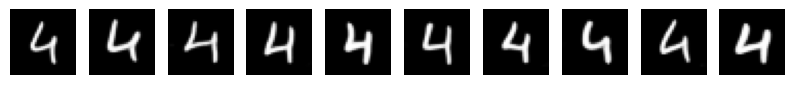

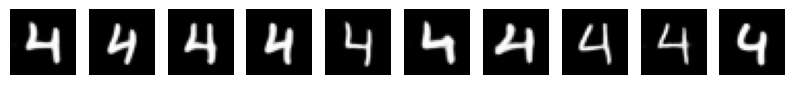

In [8]:
# look at some nearby points in the latent space
idx = 1
test_latent = latent_filtered_images[idx]

dists = np.linalg.norm(latent_filtered_images - test_latent, axis=1)

sorted_indices = np.argsort(dists)

num_close_points = 50
closest_indices = sorted_indices[:num_close_points]

# Plot some of the points closest to the test point
plot_images(decoded_filtered_images[closest_indices[10:]], n=10)
plot_images(decoded_filtered_images[closest_indices[-10:]], n=10)

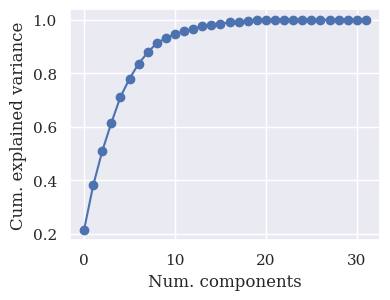

In [9]:
# PCA analysis of the nearest points in the latent space, to verify if they lie on a low-dimensional subspace
from sklearn.decomposition import PCA

nearby_latents = latent_filtered_images[closest_indices]
decoded_nearby_latents = decoded_filtered_images[closest_indices]
latent_diffs = nearby_latents - test_latent

pca = PCA()
pca_latents = pca.fit_transform(latent_diffs)

explained = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(4, 3))

plt.plot(explained, marker='o')
plt.xlabel('Num. components')
plt.ylabel('Cum. explained variance')
plt.grid(True)

plt.savefig(f'figures/mnist_pca_explained_variance_{digit}s.pdf', bbox_inches='tight')
plt.show()

## construct the empirical dataset and manifold
- We pick a small subset of points to use as the empirical dataset, for running the diffusion model
- We use all the points in the class as a proxy for the true manifold

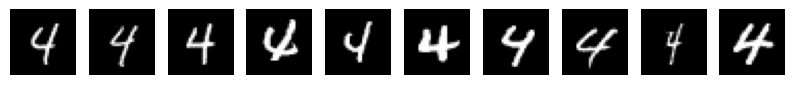

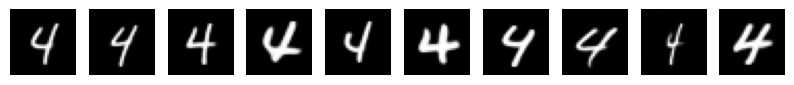

In [10]:
rng = jax.random.PRNGKey(0)
num_train_images = 100

random_train_idxs = jax.random.choice(rng, jnp.arange(len(filtered_train_images)), shape=(num_train_images,), replace=False)

train_images = filtered_train_images[random_train_idxs]
latent_train_images = latent_filtered_images[random_train_idxs]  # this is the empirical dataset used in the generation
decoded_train_images = decoded_filtered_images[random_train_idxs]

plot_images(train_images)
plot_images(decoded_train_images)

## define functions for diffusion

In [11]:
ve = VE_diffuser(sigma_min=0.001, sigma_max=3.0)

In [12]:
# helper functions to find closest latent training point to a given sample
def get_closest_latent_idx(sample):
  dists = jnp.linalg.norm(latent_train_images - sample[None,:], axis=1)
  closest_idx = np.argmin(dists)
  return closest_idx, dists[closest_idx]

def get_closest_latent_idx_in_manifold(sample):
  dists = jnp.linalg.norm(latent_filtered_images - sample[None,:], axis=1)
  closest_idx = np.argmin(dists)
  return closest_idx, dists[closest_idx]

## empirical score generations
- Now let's run the diffusion generation process, but using the empirical score function
- This should generate only training samples

Decoded generations


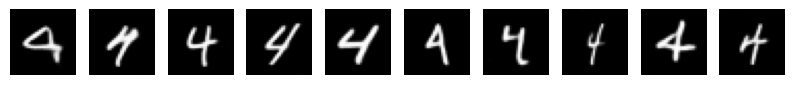

---------------------------------------
Decoded closest points in the training set


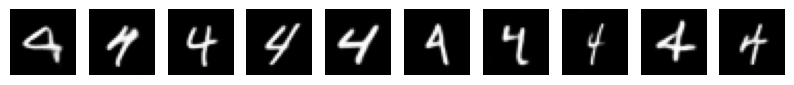

Distance to nearest training datapoint: [0.00584646 0.00616534 0.00518955 0.0070866  0.00629814 0.00620749
 0.00488926 0.00559388 0.00537286 0.00501467]
---------------------------------------
Decoded closest points in the manifold


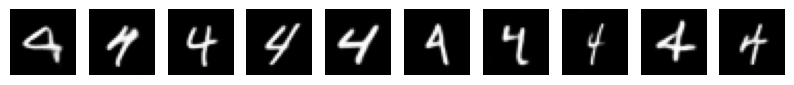

Distance to nearest point on manifold: [0.00584646 0.00616534 0.00518955 0.0070866  0.00629814 0.00620749
 0.00488926 0.00559388 0.00537286 0.00501467]


In [13]:
num_samples = 10

latent_dim = vae_config['model_config']['latent_dim']
image_shape = (latent_dim,)

# create the empirical eps prediction function
data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, latent_train_images, t)

# run the sampling, which generates samples in the latent space
key = jax.random.PRNGKey(0)
xs, traj = sample_rev(ve, key, data_empirical_eps_fn, num_samples, image_shape=image_shape, num_steps=100)

# decode the samples to images
reconstructed_xs = vae.apply(params, xs, method=vae.decode)

print('Decoded generations')
plot_images(reconstructed_xs, n=num_samples)

print('---------------------------------------')
print('Decoded closest points in the training set')
init_closest_latent_idxs, dists = jax.vmap(get_closest_latent_idx)(xs)
plot_images(decoded_train_images[init_closest_latent_idxs], n=num_samples)
print('Distance to nearest training datapoint:', dists)

print('---------------------------------------')
print('Decoded closest points in the manifold')
closest_latent_idxs_to_manifold, dists = jax.vmap(get_closest_latent_idx_in_manifold)(xs)
plot_images(decoded_filtered_images[closest_latent_idxs_to_manifold], n=num_samples)
print('Distance to nearest point on manifold:', dists)

- Indeed, running the diffusion with the empirical score function recovers only training data
- The closest point on the manifold (approximated by all the points in the class) coincides with the closest point in the empirical dataset

## Running a smoothed diffusion model
- Now, let's run the diffusion model with a Gaussian-smoothed empirical score function

init closest point - the point recovered when using the empirical score function


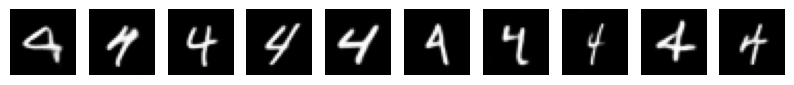

---------------------------------------
Decoded generations, using the smoothed score function


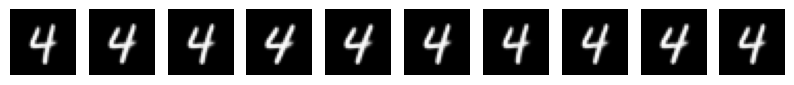

---------------------------------------
Decoded closest points in the training set


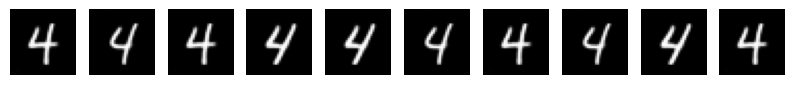

Distance to nearest training datapoint: [1.1124539 1.2547066 1.2147673 1.0712767 1.2354083 1.2376221 1.1281965
 1.2845272 1.2069125 1.2785721]
---------------------------------------
Decoded closest points in the manifold


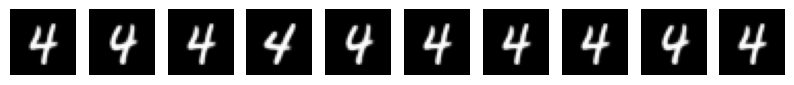

Distance to nearest point on manifold: [0.9348241  0.9416969  0.9178128  1.047666   0.9849163  0.8913434
 0.93058616 0.95208514 1.0021372  0.94740534]


In [14]:
# run smoothed diffusion
num_samples = 10

# create the empirical eps prediction function
data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, latent_train_images, t)

# create the smoothed version of the empirical eps prediction function
smoothing_param = 0.7
smoothed_emp_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n=1000) #n=50000)     # increase n for better smoothing accuracy

# run the sampling, which generates samples in the latent space
key = jax.random.PRNGKey(0)
gaussian_smoothing_samples, traj = sample_rev(ve, key, smoothed_emp_eps_fn, num_samples, image_shape=image_shape, num_steps=100)

# decode the samples to images
reconstructed_gaussian_smoothing_samples = vae.apply(params, gaussian_smoothing_samples, method=vae.decode)

print('init closest point - the point recovered when using the empirical score function') # The point that is obtained when no smoothing is applied
plot_images(decoded_train_images[init_closest_latent_idxs], n=num_samples)

print('---------------------------------------')
print('Decoded generations, using the smoothed score function')
plot_images(reconstructed_gaussian_smoothing_samples, n=num_samples)

print('---------------------------------------')
print('Decoded closest points in the training set')
closest_latent_idxs, dists = jax.vmap(get_closest_latent_idx)(gaussian_smoothing_samples)
plot_images(decoded_train_images[closest_latent_idxs], n=num_samples)
print('Distance to nearest training datapoint:', dists)

print('---------------------------------------')
print('Decoded closest points in the manifold')
closest_latent_idxs_to_manifold, dists = jax.vmap(get_closest_latent_idx_in_manifold)(gaussian_smoothing_samples)
plot_images(decoded_filtered_images[closest_latent_idxs_to_manifold], n=num_samples)
print('Distance to nearest point on manifold:', dists)

- For samples from the smoothed-score diffusion model, the closest point on the manifold does not always correspond to the closest point in the empirical training dataset - there is often an example in the wider set that is closer than the points in the training dataset.

## KDE samples
- Now, we will instead generate samples using KDE in the latent space

init closest point (used as mean for the KDE)


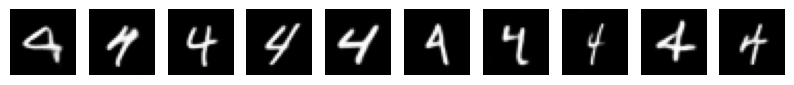

---------------------------------------
Decoded KDE generated samples


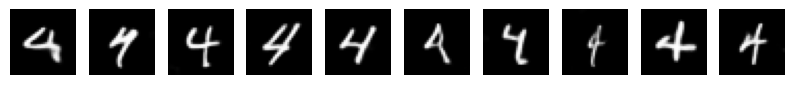

---------------------------------------
Decoded closest points in the training set


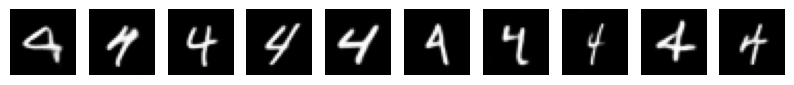

Distance to nearest training datapoint: [1.0873803 1.3578163 1.2965357 0.9259086 1.4354837 1.1430676 1.1529609
 1.165976  1.0739847 0.9342737]
---------------------------------------
Decoded closest points in the manifold


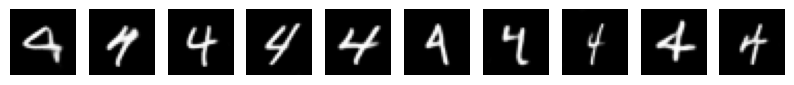

Distance to nearest point on manifold: [1.0873802 1.3578163 1.2965357 0.9259086 1.3978801 1.1430676 1.1529609
 1.165976  1.0739847 0.9342737]


In [15]:
srng = jax.random.PRNGKey(1)

latent_sigma = 0.2

latent_noise = jax.random.normal(srng, (num_samples, latent_dim)) * latent_sigma

# for the means, use the point that is recovered when using diffusion with empirical score (for visual comparison)
KDE_latents = latent_train_images[init_closest_latent_idxs] + latent_noise

decoded_KDE_generations = vae.apply(params, KDE_latents, method=vae.decode)

print('init closest point (used as mean for the KDE)') # The point that is obtained when no smoothing is applied
plot_images(decoded_train_images[init_closest_latent_idxs], n=num_samples)

print('---------------------------------------')
print('Decoded KDE generated samples')
plot_images(decoded_KDE_generations, n=num_samples)

print('---------------------------------------')
print('Decoded closest points in the training set')
KDE_closest_latent_idxs, dists = jax.vmap(get_closest_latent_idx)(KDE_latents)
plot_images(decoded_train_images[KDE_closest_latent_idxs], n=num_samples)
print('Distance to nearest training datapoint:', dists)

print('---------------------------------------')
print('Decoded closest points in the manifold')
KDE_closest_latent_idxs_to_manifold, dists = jax.vmap(get_closest_latent_idx_in_manifold)(KDE_latents)
plot_images(decoded_filtered_images[KDE_closest_latent_idxs_to_manifold], n=num_samples)
print('Distance to nearest point on manifold:', dists)

- For KDE, the closest point on the manifold usually corresponds to the closest point in the empirical dataset (see the plot below)

## making the plots
- We will run the Gaussian-smoothed diffusion model, for several different smoothing levels, and plot the distance the the manifold against the distance to the training data
- We will also do the same for KDE
- The smoothing levels are selected to induce similar distances from the training dataset

In [16]:
# gaussian smoothing
gaussian_smoothing_params = [0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
num_samples = 500

data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, latent_train_images, t)

gaussian_dataset_dists = []
gaussian_manifold_dists = []

for smoothing_param in gaussian_smoothing_params:
    print(f'Smoothing parameter: {smoothing_param}')
    
    smoothed_emp_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n=1000) #n=50000)

    key = jax.random.PRNGKey(0)
    gaussian_smoothing_samples, traj = sample_rev(ve, key, smoothed_emp_eps_fn, num_samples, image_shape=image_shape, num_steps=100)

    closest_latent_idxs, dists = jax.vmap(get_closest_latent_idx)(gaussian_smoothing_samples)
    gaussian_dataset_dists.append(dists)

    closest_latent_idxs_to_manifold, dists = jax.vmap(get_closest_latent_idx_in_manifold)(gaussian_smoothing_samples)
    gaussian_manifold_dists.append(dists)

gaussian_dataset_dists = jnp.array(gaussian_dataset_dists)  # Shape: (num_smoothing_params, num_samples)
gaussian_manifold_dists = jnp.array(gaussian_manifold_dists) # Shape: (num_smoothing_params, num_samples)

average_gaussian_dataset_dists = jnp.mean(jnp.array(gaussian_dataset_dists), axis=1)
average_gaussian_manifold_dists = jnp.mean(jnp.array(gaussian_manifold_dists), axis=1)

Smoothing parameter: 0.4


Smoothing parameter: 0.45
Smoothing parameter: 0.5
Smoothing parameter: 0.6
Smoothing parameter: 0.7
Smoothing parameter: 0.8
Smoothing parameter: 0.9


In [17]:
# KDE
KDE_params = [0.07, 0.1, 0.13, 0.16, 0.19, 0.22, 0.25]

# We will centre the KDE samples at the same corresponding datapoints as are recovered from using the empirical score function, to allow for visual comparison
data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, latent_train_images, t)
init_samples, _ = sample_rev(ve, key, data_empirical_eps_fn, num_samples, image_shape=image_shape, num_steps=100)
closest_latent_idxs, dists = jax.vmap(get_closest_latent_idx)(init_samples)

KDE_means = latent_train_images[closest_latent_idxs]  # Use the closest points from the initial samples
init_images = decoded_filtered_images[closest_latent_idxs]  # Use the decoded images of the closest points

KDE_dataset_dists = []
KDE_manifold_dists = []

key = jax.random.PRNGKey(0)

for KDE_param in KDE_params:
    print(f'KDE parameter: {KDE_param}')
    
    key, srng = jax.random.split(key)
    latent_noise = jax.random.normal(srng, (num_samples, latent_dim)) * KDE_param

    KDE_latents = KDE_means + latent_noise

    closest_latent_idxs, dists = jax.vmap(get_closest_latent_idx)(KDE_latents)
    KDE_dataset_dists.append(dists)

    closest_latent_idxs_to_manifold, dists = jax.vmap(get_closest_latent_idx_in_manifold)(KDE_latents)
    KDE_manifold_dists.append(dists)

KDE_dataset_dists = jnp.array(KDE_dataset_dists)  # Shape: (num_smoothing_params, num_samples)
KDE_manifold_dists = jnp.array(KDE_manifold_dists) # Shape: (num_smoothing_params, num_samples)

average_KDE_dataset_dists = jnp.mean(jnp.array(KDE_dataset_dists), axis=1)
average_KDE_manifold_dists = jnp.mean(jnp.array(KDE_manifold_dists), axis=1)

KDE parameter: 0.07
KDE parameter: 0.1
KDE parameter: 0.13
KDE parameter: 0.16
KDE parameter: 0.19
KDE parameter: 0.22
KDE parameter: 0.25


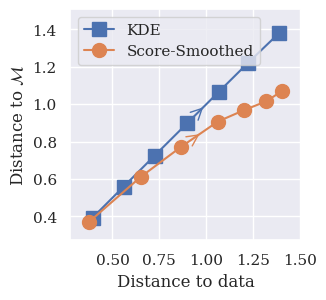

In [18]:
# make plot

# Plot scatter plot
plt.figure(figsize=(3,3))

# Plot and add arrow for manifold-adapted line
line1 = plt.plot(average_KDE_dataset_dists, average_KDE_manifold_dists,
                 marker='s', ms=10, label='KDE')[0]
add_arrows(line1, 3, color=line1.get_color())  # Add arrow on 4th segment

# Plot and add arrow for isotropic gaussian line
line2 = plt.plot(average_gaussian_dataset_dists, average_gaussian_manifold_dists,
                 marker='o', ms=10, label='Score-Smoothed')[0]
add_arrows(line2, 2, color=line2.get_color())  # Add arrow on 3rd segment

plt.xlabel("Distance to data")
plt.ylabel("Distance to $\mathcal{M}$")
plt.grid(True)

# Add y = x line
min_val = min(average_KDE_manifold_dists.min(), average_KDE_dataset_dists.min(), average_gaussian_manifold_dists.min(), average_gaussian_dataset_dists.min())
max_val = max(average_KDE_manifold_dists.max(), average_KDE_dataset_dists.max(), average_gaussian_manifold_dists.max(), average_gaussian_dataset_dists.max())
# plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')

plt.legend(loc='upper left')
plt.xlim(min_val-0.1, max_val+0.1)
plt.ylim(min_val-0.1, max_val+0.1)
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("figures/mnist_KDE_smoothing_L2_4s.pdf", bbox_inches='tight', dpi=1000)

plt.show()

- For KDE, the line increases like $y=x$. This shows that, as the smoothing level increases, the closest point in the wider dataset still coincides with the point in the training dataset from which the KDE sample was obtained by adding noise (as would be expected)
- In contrast, the samples from the smoothed-score diffusion model sometimes become closer to unseen samples from the wider dataset that are not present in the empirical training dataset (indicated by the downwards slope)

## now, we can show a visualisation of what this means for the reconstructions
- The quality of the VAE reconstruction can be used as a proxy for how 'on-manifold' the generations in the latent space are
- For fair comparison, we will choose the smoothing levels to induce the same amount of 'along manifold' movement (on average) - this corresponds to inducing the same level of 'novelty' in the generations
- We will plot a single generation, as the amount of smoothing increases

In [47]:
# gaussian smoothing
gaussian_smoothing_params = [0.3, 0.4, 0.5, 0.7]

num_samples = 500

data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, latent_train_images, t)

gaussian_dataset_dists = []
gaussian_manifold_dists = []
gaussian_lateral_dists = []
gaussian_samples = []
gaussian_latent_samples = []

sample_key = jax.random.PRNGKey(0)

for smoothing_param in gaussian_smoothing_params:
    print(f'Smoothing parameter: {smoothing_param}')
    
    smoothed_emp_eps_fn = get_smoothed_fn(data_empirical_eps_fn, smoothing_param, n=1000) #n=50000)

    
    gaussian_smoothing_samples, traj = sample_rev(ve, sample_key, smoothed_emp_eps_fn, num_samples, image_shape=image_shape, num_steps=100)

    closest_latent_idxs, data_dists = jax.vmap(get_closest_latent_idx)(gaussian_smoothing_samples)
    gaussian_dataset_dists.append(data_dists)

    closest_latent_idxs_to_manifold, manifold_dists = jax.vmap(get_closest_latent_idx_in_manifold)(gaussian_smoothing_samples)
    gaussian_manifold_dists.append(manifold_dists)

    # Calculate lateral distances, i.e. movement 'along the manifold'
    lateral_dists = jnp.sqrt(data_dists**2 - manifold_dists**2)
    gaussian_lateral_dists.append(lateral_dists)

    decoded_samples = vae.apply(params, gaussian_smoothing_samples, method=vae.decode)
    gaussian_samples.append(decoded_samples)

    gaussian_latent_samples.append(gaussian_smoothing_samples)

gaussian_dataset_dists = jnp.array(gaussian_dataset_dists)  # Shape: (num_smoothing_params, num_samples)
gaussian_manifold_dists = jnp.array(gaussian_manifold_dists) # Shape: (num_smoothing_params, num_samples)
gaussian_lateral_dists = jnp.array(gaussian_lateral_dists) # Shape: (num_smoothing_params, num_samples)

gaussian_samples = jnp.array(gaussian_samples)  # Shape: (num_smoothing_params, num_samples, image_height, image_width, channels)
gaussian_latent_samples = jnp.array(gaussian_latent_samples)  # Shape: (num_smoothing_params, num_samples, latent_dim)

average_gaussian_dataset_dists = jnp.mean(jnp.array(gaussian_dataset_dists), axis=1)
average_gaussian_manifold_dists = jnp.mean(jnp.array(gaussian_manifold_dists), axis=1)
average_gaussian_lateral_dists = jnp.mean(jnp.array(gaussian_lateral_dists), axis=1)

Smoothing parameter: 0.3
Smoothing parameter: 0.4
Smoothing parameter: 0.5
Smoothing parameter: 0.7


In [48]:
# KDE
KDE_params = [0.1, 0.2, 0.4, 0.5] # chosen to induce similar lateral distances to the gaussian smoothing params

key = jax.random.PRNGKey(42)
data_empirical_eps_fn = lambda x, t, key: empirical_eps_fn(x, latent_train_images, t)

init_samples, _ = sample_rev(ve, sample_key, data_empirical_eps_fn, num_samples, image_shape=image_shape, num_steps=100)
closest_latent_idxs, dists = jax.vmap(get_closest_latent_idx)(init_samples)

KDE_means = latent_train_images[closest_latent_idxs]  # Use the closest points from the initial samples
init_images = decoded_train_images[closest_latent_idxs]  # Use the decoded images of the closest points

KDE_samples = []
KDE_dataset_dists = []
KDE_manifold_dists = []
KDE_lateral_dists = []

for KDE_param in KDE_params:
    print(f'KDE parameter: {KDE_param}')
    
    key, srng = jax.random.split(key)
    latent_noise = jax.random.normal(srng, (num_samples, latent_dim)) * KDE_param

    KDE_latents = KDE_means + latent_noise

    closest_latent_idxs, data_dists = jax.vmap(get_closest_latent_idx)(KDE_latents)
    KDE_dataset_dists.append(data_dists)

    closest_latent_idxs_to_manifold, manifold_dists = jax.vmap(get_closest_latent_idx_in_manifold)(KDE_latents)
    KDE_manifold_dists.append(manifold_dists)

    # Calculate lateral distances
    lateral_dists = jnp.sqrt(data_dists**2 - manifold_dists**2)
    KDE_lateral_dists.append(lateral_dists)

    decoded_samples = vae.apply(params, KDE_latents, method=vae.decode)
    KDE_samples.append(decoded_samples)


KDE_dataset_dists = jnp.array(KDE_dataset_dists)  # Shape: (num_smoothing_params, num_samples)
KDE_manifold_dists = jnp.array(KDE_manifold_dists) # Shape: (num_smoothing_params, num_samples)
KDE_lateral_dists = jnp.array(KDE_lateral_dists) # Shape: (num_smoothing_params, num_samples)

KDE_samples = jnp.array(KDE_samples)  # Shape: (num_smoothing_params, num_samples, latent_dim)

average_KDE_dataset_dists = jnp.mean(jnp.array(KDE_dataset_dists), axis=1)
average_KDE_manifold_dists = jnp.mean(jnp.array(KDE_manifold_dists), axis=1)
average_KDE_lateral_dists = jnp.mean(jnp.array(KDE_lateral_dists), axis=1)

KDE parameter: 0.1
KDE parameter: 0.2
KDE parameter: 0.4
KDE parameter: 0.5


In [49]:
# check that the chosen smoothing levels induce similar lateral distances 'along the manifold'
print("Average Gaussian dataset distances:", average_gaussian_lateral_dists)
print("Average KDE lateral distances:", average_KDE_lateral_dists)

Average Gaussian dataset distances: [0.         0.01552556 0.3301541  0.69091827]
Average KDE lateral distances: [0.         0.01301938 0.39842033 0.66573495]


- Now display the generations

In [50]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_smoothing_grid(data_point, plot_gaussian_samples, plot_KDE_samples, savefig=None):
    """
    Plot a data point on the left and grids of Gaussian / KDE samples on the right.
    
    Args:
        data_point: array-like, image (H, W) or (H, W, 1)
        plot_gaussian_samples: array-like of shape (4, H, W, 1) or (4, H, W)
        plot_KDE_samples: array-like of shape (4, H, W, 1) or (4, H, W)
        savefig: str or None, if provided saves the figure to this path
    """
    fig = plt.figure(figsize=(10, 5))

    # GridSpec with 6 columns, second column is a spacer
    gs = gridspec.GridSpec(2, 6, figure=fig,
                           width_ratios=[2, 0.3, 2, 2, 2, 2],
                           hspace=0.1, wspace=0.1)

    # Left image
    ax_left = fig.add_subplot(gs[:, 0])
    ax_left.imshow(data_point.squeeze(), cmap='gray', vmin=0, vmax=1)
    ax_left.set_title('Data Point', fontsize=18, pad=10)
    ax_left.axis('off')

    # Titles over the right grids
    fig.text(0.61, 0.88, r'Increasing Score Smoothing $\longrightarrow$', 
             ha='center', va='center', fontsize=18)
    fig.text(0.61, 0.48, r'Increasing KDE Bandwidth $\longrightarrow$', 
             ha='center', va='center', fontsize=18)

    # Top row: Gaussian samples
    for i in range(4):
        ax = fig.add_subplot(gs[0, i + 2])
        ax.imshow(plot_gaussian_samples[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        ax.axis('off')

    # Bottom row: KDE samples
    for i in range(4):
        ax = fig.add_subplot(gs[1, i + 2])
        ax.imshow(plot_KDE_samples[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        ax.axis('off')

    # Layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_411711/633970970.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


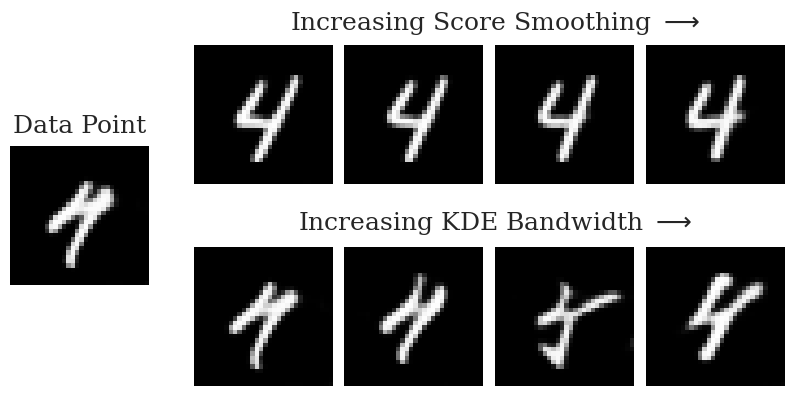

/tmp/ipykernel_411711/633970970.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


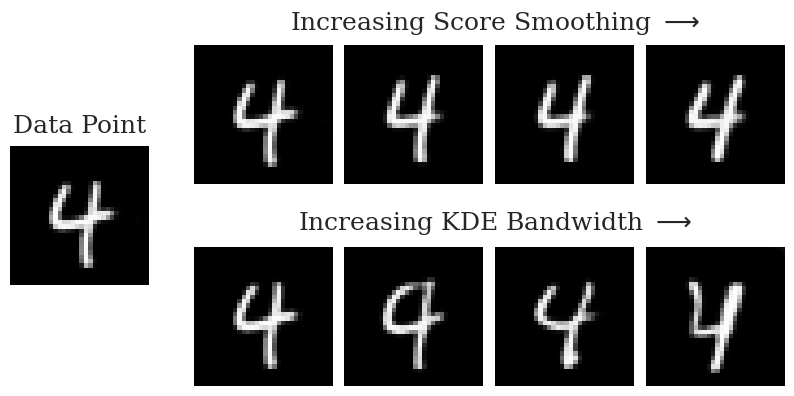

/tmp/ipykernel_411711/633970970.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


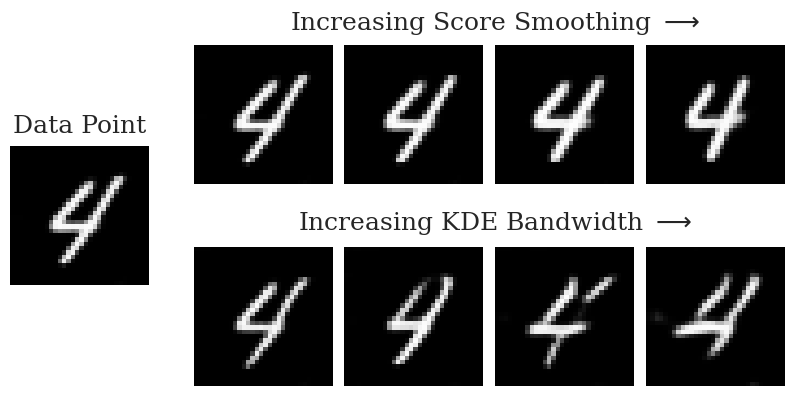

/tmp/ipykernel_411711/633970970.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


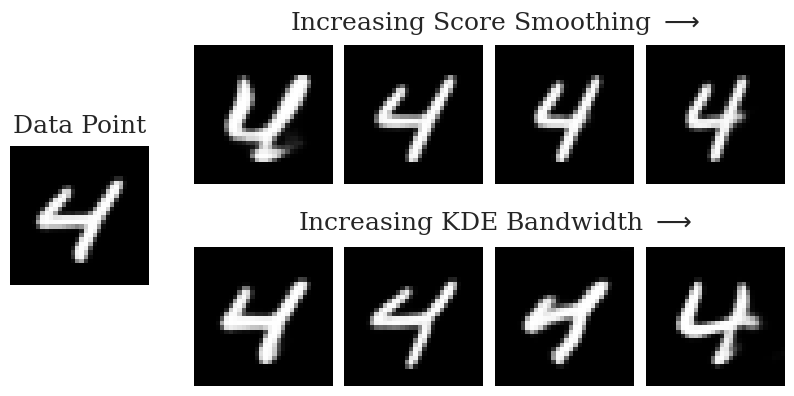

In [51]:
idx = 1
plot_smoothing_grid(init_images[idx], gaussian_samples[:,idx],  KDE_samples[:,idx], savefig="figures/mnist_KDE_smoothing_plots_4s.pdf")

idx = 2
plot_smoothing_grid(init_images[idx], gaussian_samples[:,idx],  KDE_samples[:,idx], savefig="figures/mnist_KDE_smoothing_plots_4s_2.pdf")

idx = 3
plot_smoothing_grid(init_images[idx], gaussian_samples[:,idx],  KDE_samples[:,idx], savefig="figures/mnist_KDE_smoothing_plots_4s_3.pdf")

idx = 4
plot_smoothing_grid(init_images[idx], gaussian_samples[:,idx],  KDE_samples[:,idx], savefig="figures/mnist_KDE_smoothing_plots_4s_4.pdf")

## check whether the generated samples are novel, as smoothing increases
- Finally, for the samples plotted above we also plot the closest points in the training dataset, to check it is not just memorising a different datapoint

---------------------------------------
Decoded generated samples


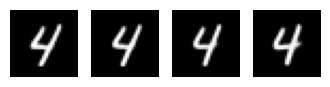

---------------------------------------
Decoded closest points in the training set


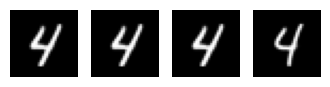

Distance to nearest training datapoint: [0.09189866 0.50719416 0.9999488  1.2547066 ]
---------------------------------------
Decoded closest points in the manifold


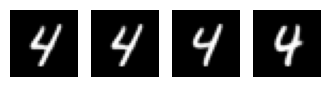

Distance to nearest point on manifold: [0.09189866 0.50719416 0.7654572  0.9416969 ]


In [52]:
idx = 1

data_point = init_images[idx]
plot_gaussian_latent_samples = gaussian_latent_samples[:,idx]

decoded_generations = vae.apply(params, plot_gaussian_latent_samples, method=vae.decode)

print('---------------------------------------')
print('Decoded generated samples')
plot_images(decoded_generations, n=4)

print('---------------------------------------')
print('Decoded closest points in the training set')
closest_latent_idxs, dists = jax.vmap(get_closest_latent_idx)(plot_gaussian_latent_samples)
plot_images(decoded_train_images[closest_latent_idxs], n=4)
print('Distance to nearest training datapoint:', dists)

print('---------------------------------------')
print('Decoded closest points in the manifold')
closest_latent_idxs_to_manifold, dists = jax.vmap(get_closest_latent_idx_in_manifold)(plot_gaussian_latent_samples)
plot_images(decoded_filtered_images[closest_latent_idxs_to_manifold], n=4)
print('Distance to nearest point on manifold:', dists)

As the smoothing increases and the generations of the score-smoothed diffusion model change, they do indeed create samples not present in the training data